In [1]:
!git clone https://github.com/tlpss/keypoint-detection.git
%cd keypoint-detection/
%cd ..

Cloning into 'keypoint-detection'...
remote: Enumerating objects: 987, done.
remote: Counting objects: 100% (584/584), done.
remote: Compressing objects: 100% (226/226), done.
remote: Total 987 (delta 420), reused 451 (delta 357), pack-reused 403 (from 1)
Receiving objects: 100% (987/987), 3.70 MiB | 14.04 MiB/s, done.
Resolving deltas: 100% (565/565), done.
/kaggle/working/keypoint-detection
/kaggle/working


In [2]:
!pip install pytorch
!pip install torchvision
!pip install wandb
!pip install setuptools
!pip install torch
!pip install torchvision
!pip install pytorch-lightning
!pip install torchmetrics
!pip install wandb
!pip install timm
!pip install tqdm
!pip install pytest
!pip install pre-commit
!pip install scikit-image
!pip install albumentations
!pip install matplotlib
!pip install pydantic
!pip install fiftyone

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-x2ai7tsm/pytorch_aa97bc7f2490401085cde5521a3ea540/setup.py", line 15, in <module>
          raise Exception(message)
      Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
ERROR: Could not build wheels for pytorch, which is required to install pyproject.toml-based projects
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.7/218.7 kB 4.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
pip install -e



Usage:   
  /opt/conda/bin/python3.10 -m pip install [options] <requirement specifier> [package-index-options] ...
  /opt/conda/bin/python3.10 -m pip install [options] -r <requirements file> [package-index-options] ...
  /opt/conda/bin/python3.10 -m pip install [options] [-e] <vcs project url> ...
  /opt/conda/bin/python3.10 -m pip install [options] [-e] <local project path> ...
  /opt/conda/bin/python3.10 -m pip install [options] <archive url/path> ...

-e option requires 1 argument
Note: you may need to restart the kernel to use updated packages.


In [5]:
import sys
sys.path.append('/kaggle/working/keypoint-detection')



***TYPE***

In [6]:
    """ avoid circular imports by separating types"""
from typing import List, Tuple

KEYPOINT_TYPE = Tuple[int, int]  # (u,v)
COCO_KEYPOINT_TYPE = Tuple[int, int, int]  # (u,v,f)
CHANNEL_KEYPOINTS_TYPE = List[KEYPOINT_TYPE]
IMG_KEYPOINTS_TYPE = List[CHANNEL_KEYPOINTS_TYPE]

***augmentations***

In [7]:
import typing
from typing import List

import albumentations as A

from keypoint_detection.types import IMG_KEYPOINTS_TYPE, KEYPOINT_TYPE


class MultiChannelKeypointsCompose(A.Compose):
    """A subclass of Albumentations.Compose to accomodate for multiple groups/channels of keypoints.
    Some transforms (crop e.g.) will result in certain keypoints no longer being in the new image. Albumentations can remove them, but since it operates
    on a single list of keypoints, the transformed keypoints need to be associated to their channel afterwards. Albumentations has support for labels to accomodate this,
    so we label each keypoint with the index of its channel.
    """

    def __init__(self, transforms, p: float = 1):
        keypoint_params = A.KeypointParams(format="xy", label_fields=["channel_labels"], remove_invisible=True)
        super().__init__(transforms, keypoint_params=keypoint_params, p=p)

    def __call__(self, *args, force_apply: bool = False, **data) -> typing.Dict[str, typing.Any]:

        # flatten and create channel labels (=str(index))
        keypoints = data["keypoints"]
        self.create_channel_labels(keypoints)
        flattened_keypoints = self.flatten_keypoints(keypoints)
        data["keypoints"] = flattened_keypoints
        data["channel_labels"] = self.flatten_keypoints(self.create_channel_labels(keypoints))
        # apply transforms
        result_dict = super().__call__(*args, force_apply=force_apply, **data)

        # rearrange keypoints by channel
        transformed_flattened_keypoints = result_dict["keypoints"]
        transformed_flattened_labels = result_dict["channel_labels"]
        transformed_keypoints = self.order_transformed_keypoints_by_channel(
            keypoints, transformed_flattened_keypoints, transformed_flattened_labels
        )
        result_dict["keypoints"] = transformed_keypoints
        return result_dict

    @staticmethod
    def flatten_keypoints(keypoints: IMG_KEYPOINTS_TYPE) -> List[KEYPOINT_TYPE]:
        return [item for sublist in keypoints for item in sublist]

    @staticmethod
    def create_channel_labels(keypoints: IMG_KEYPOINTS_TYPE):
        channel_labels = [[str(i)] * len(keypoints[i]) for i in range(len(keypoints))]
        return channel_labels

    @staticmethod
    def order_transformed_keypoints_by_channel(
        original_keypoints: IMG_KEYPOINTS_TYPE,
        transformed_keypoints: List[KEYPOINT_TYPE],
        transformed_channel_labels: List[str],
    ) -> IMG_KEYPOINTS_TYPE:
        ordered_transformed_keypoints = [[] for _ in original_keypoints]
        for transformed_keypoint, channel_label in zip(transformed_keypoints, transformed_channel_labels):
            channel_idx = int(channel_label)
            ordered_transformed_keypoints[channel_idx].append(transformed_keypoint)

        return ordered_transformed_keypoints

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


***coco_parser***

In [8]:
from typing import List, Optional, Union

from pydantic import BaseModel

"""Custom parser for COCO keypoints JSON"""

LicenseID = int
ImageID = int
CategoryID = int
AnnotationID = int
Segmentation = List[List[Union[float, int]]]
FileName = str
Relativepath = str
Url = str


class CocoInfo(BaseModel):
    description: str
    url: Url
    version: str
    year: int
    contributor: str
    date_created: str


class CocoLicenses(BaseModel):
    url: Url
    id: LicenseID
    name: str


class CocoImage(BaseModel):
    license: Optional[LicenseID] = None
    file_name: Relativepath
    height: int
    width: int
    id: ImageID


class CocoKeypointCategory(BaseModel):
    supercategory: str  # should be set to "name" for root category
    id: CategoryID
    name: str
    keypoints: List[str]
    skeleton: Optional[List[List[int]]] = None


class CocoKeypointAnnotation(BaseModel):
    category_id: CategoryID
    id: AnnotationID
    image_id: ImageID

    num_keypoints: Optional[int] = None
    # COCO keypoints can be floats if they specify the exact location of the keypoint (e.g. from CVAT)
    # even though COCO format specifies zero-indexed integers (i.e. every keypoint in the [0,1]x [0.1] pixel box becomes (0,0)
    keypoints: List[float]

    # TODO: add checks.
    # @validator("keypoints")
    # def check_amount_of_keypoints(cls, v, values, **kwargs):
    #     assert len(v) // 3 == values["num_keypoints"]


class CocoKeypoints(BaseModel):
    """Parser Class for COCO keypoints JSON

    Example:
    with open("path","r") as file:
        data = json.load(file) # dict
        parsed_data = COCOKeypoints(**data)
    """

    info: Optional[CocoInfo] = None
    licenses: Optional[List[CocoLicenses]] = None
    images: List[CocoImage]
    categories: List[CocoKeypointCategory]
    annotations: List[CocoKeypointAnnotation]


***imageloader***

In [9]:
import abc
import random
import time

import numpy as np
from skimage import io
from torch.utils.data import Dataset


class ImageLoader:
    def get_image(self, path: str, idx: int) -> np.ndarray:
        """
        read the image from disk and return as np array
        """
        # load images @runtime from disk
        image = io.imread(path)
        return image


class BaseImageLoaderDecorator(ImageLoader):
    def __init__(self, image_loader: ImageLoader) -> None:
        self.image_loader = image_loader

    @abc.abstractmethod
    def get_image(self, path: str, idx: int) -> np.ndarray:
        pass


class IOSafeImageLoaderDecorator(BaseImageLoaderDecorator):
    """
    IO safe loader that re-attempts to load image from disk (important for GPULab infrastructure @ UGent)
    """

    def __init__(self, image_loader: ImageLoader) -> None:
        super().__init__(image_loader)
        self.n_io_attempts = 4

    def get_image(self, path: str, idx: int) -> np.ndarray:
        sleep_time_in_seconds = 1
        for j in range(self.n_io_attempts):
            try:
                image = self.image_loader.get_image(path, idx)
                return image
            except IOError:
                if j == self.n_io_attempts - 1:
                    raise IOError(f"Could not load image for dataset entry with path {path}, index {idx}")

                sleep_time = max(random.gauss(sleep_time_in_seconds, j), 0)
                print(f"caught IOError in {j}th attempt to load image for {path}, sleeping for {sleep_time} seconds")
                time.sleep(sleep_time)
                sleep_time_in_seconds *= 2


class CachedImageLoaderDecorator(BaseImageLoaderDecorator):
    """
    Image dataloader that caches the images after the first fetch in np.uint8 format.
    Requires enough CPU Memory to fit entire dataset (img_size^2*3*N_images B)

    This is done lazy instead of prefetching, as the torch dataloader is highly optimized to prefetch data during forward passes etc.
     Impact is expected to be not too big.. TODO -> benchmark.

    Furthermore, this caching requires to set num_workers to 0, as the dataset object is copied by each dataloader worker.
    """

    def __init__(self, image_loader: ImageLoader) -> None:
        super().__init__(image_loader)

        self.cache = []
        self.cache_index_mapping = {}

    def get_image(self, path: str, idx: int) -> np.ndarray:
        if path not in self.cache_index_mapping:
            img = super().get_image(path, idx)
            self.cache.append(img)
            self.cache_index_mapping.update({path: len(self.cache) - 1})
            return img

        else:
            return self.cache[self.cache_index_mapping[path]]


class ImageDataset(Dataset, abc.ABC):
    def __init__(self, imageloader: ImageLoader = None):
        if imageloader is None:
            self.image_loader = IOSafeImageLoaderDecorator(ImageLoader())

        else:
            assert isinstance(imageloader, ImageLoader)
            self.image_loader = imageloader

    def __getitem__(self, index):
        pass

    def __len__(self):
        pass


***unlabeled_dataset***

In [10]:
import os

import torch
from torchvision.transforms import ToTensor

from keypoint_detection.data.imageloader import ImageDataset


class UnlabeledKeypointsDataset(ImageDataset):
    """
    Simple dataset to run inference on unlabeled data
    """

    def __init__(
        self,
        image_dataset_path: str,
        **kwargs,
    ):
        super().__init__()
        self.image_paths = os.listdir(image_dataset_path)
        self.image_paths = [image_dataset_path + f"/{path}" for path in self.image_paths]

        self.transform = ToTensor()  # convert images to Torch Tensors

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        index = int(index)

        image_path = self.image_paths[index]
        image = self.image_loader.get_image(image_path, index)
        image = self.transform(image)

        return image

    def __len__(self):
        return len(self.image_paths)



***datamodule***

In [11]:
import argparse
import random

import albumentations as A
import numpy as np
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, Subset

from keypoint_detection.data.augmentations import MultiChannelKeypointsCompose
from keypoint_detection.data.coco_dataset import COCOKeypointsDataset


class KeypointsDataModule(pl.LightningDataModule):
    @staticmethod
    def add_argparse_args(parent_parser: argparse.ArgumentParser) -> argparse.ArgumentParser:
        """
        add named arguments from the init function to the parser
        """
        parser = parent_parser.add_argument_group("KeypointsDatamodule")
        parser.add_argument("--batch_size", default=16, type=int)
        parser.add_argument("--validation_split_ratio", default=0.25, type=float)
        parser.add_argument("--num_workers", default=4, type=int)
        parser.add_argument(
            "--json_dataset_path",
            type=str,
            help="Absolute path to the json file that defines the train dataset according to the COCO format.",
            required=True,
        )
        parser.add_argument(
            "--json_validation_dataset_path",
            type=str,
            help="Absolute path to the json file that defines the validation dataset according to the COCO format. \
                If not specified, the train dataset will be split to create a validation set if there is one.",
        )
        parser.add_argument(
            "--json_test_dataset_path",
            type=str,
            help="Absolute path to the json file that defines the test dataset according to the COCO format. \
                If not specified, no test set evaluation will be performed at the end of training.",
        )

        parser.add_argument("--augment_train", dest="augment_train", default=False, action="store_true")
        parent_parser = COCOKeypointsDataset.add_argparse_args(parent_parser)

        return parent_parser

    def __init__(
        self,
        keypoint_channel_configuration: list[list[str]],
        batch_size: int = 16,
        validation_split_ratio: float = 0.25,
        num_workers: int = 2,
        json_dataset_path: str = None,
        json_validation_dataset_path: str = None,
        json_test_dataset_path=None,
        augment_train: bool = False,
        **kwargs,
    ):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.augment_train = augment_train

        self.train_dataset = None
        if json_dataset_path:
            self.train_dataset = COCOKeypointsDataset(json_dataset_path, keypoint_channel_configuration, **kwargs)

        self.validation_dataset = None
        self.test_dataset = None

        if json_validation_dataset_path:
            self.validation_dataset = COCOKeypointsDataset(
                json_validation_dataset_path, keypoint_channel_configuration, **kwargs
            )
        else:
            if self.train_dataset is not None:
                print(f"splitting the train set to create a validation set with ratio {validation_split_ratio} ")
                self.train_dataset, self.validation_dataset = KeypointsDataModule._split_dataset(
                    self.train_dataset, validation_split_ratio
                )

        if json_test_dataset_path:
            self.test_dataset = COCOKeypointsDataset(json_test_dataset_path, keypoint_channel_configuration, **kwargs)

        # create the transforms if needed and set them to the datasets
        if augment_train:
            print("Augmenting the training dataset!")
            img_height, img_width = self.train_dataset[0][0].shape[1], self.train_dataset[0][0].shape[2]
            aspect_ratio = img_width / img_height
            train_transform = MultiChannelKeypointsCompose(
                [
                    A.ColorJitter(p=0.8),
                    A.RandomBrightnessContrast(p=0.8),
                    A.RandomResizedCrop(
                        img_height, img_width, scale=(0.8, 1.0), ratio=(0.9 * aspect_ratio, 1.1 * aspect_ratio), p=1.0
                    ),
                    A.GaussianBlur(p=0.2, blur_limit=(3, 3)),
                    A.Sharpen(p=0.2),
                    A.GaussNoise(),
                ]
            )
            if isinstance(self.train_dataset, COCOKeypointsDataset):
                self.train_dataset.transform = train_transform
            elif isinstance(self.train_dataset, Subset):
                # if the train dataset is a subset, we need to set the transform to the underlying dataset
                # otherwise the transform will not be applied..
                assert isinstance(self.train_dataset.dataset, COCOKeypointsDataset)
                self.train_dataset.dataset.transform = train_transform

    @staticmethod
    def _split_dataset(dataset, validation_split_ratio):
        validation_size = int(validation_split_ratio * len(dataset))
        train_size = len(dataset) - validation_size
        train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_size, validation_size])
        print(f"train size: {len(train_dataset)}")
        print(f"validation size: {len(validation_dataset)}")
        return train_dataset, validation_dataset

    def train_dataloader(self):
        # usually need to seed workers for reproducibility
        # cf. https://pytorch.org/docs/stable/notes/randomness.html
        # but PL does for us in their seeding function:
        # https://lightning.ai/docs/pytorch/stable/common/trainer.html#reproducibility

        if self.train_dataset is None:
            return None

        dataloader = DataLoader(
            self.train_dataset,
            self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            collate_fn=COCOKeypointsDataset.collate_fn,
            pin_memory=True,  # usually a little faster
        )
        return dataloader

    def val_dataloader(self):
        # usually need to seed workers for reproducibility
        # cf. https://pytorch.org/docs/stable/notes/randomness.html
        # but PL does for us in their seeding function:
        # https://lightning.ai/docs/pytorch/stable/common/trainer.html#reproducibility

        if self.validation_dataset is None:
            return None

        dataloader = DataLoader(
            self.validation_dataset,
            self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            collate_fn=COCOKeypointsDataset.collate_fn,
        )
        return dataloader

    def test_dataloader(self):

        if self.test_dataset is None:
            return None
        dataloader = DataLoader(
            self.test_dataset,
            min(4, self.batch_size),  # 4 as max for better visualization in wandb.
            shuffle=False,
            num_workers=0,
            collate_fn=COCOKeypointsDataset.collate_fn,
        )
        return dataloader


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


***coco_dataset***

In [12]:
import argparse
import json
import math
import typing
from collections import defaultdict
from pathlib import Path
from typing import List, Tuple

import albumentations as A
import torch
from torchvision.transforms import ToTensor

from keypoint_detection.data.coco_parser import CocoImage, CocoKeypointCategory, CocoKeypoints
from keypoint_detection.data.imageloader import ImageDataset, ImageLoader
from keypoint_detection.types import COCO_KEYPOINT_TYPE, IMG_KEYPOINTS_TYPE


class COCOKeypointsDataset(ImageDataset):
    """Pytorch Dataset for COCO-formatted Keypoint dataset

    cf. https://cocodataset.org/#format-data for more information. We expect each annotation to have at least the keypoints and num_keypoints fields.
    Each category should also have keypoints. For more information on the required fields and data types, have a look at the COCO parser in `coco_parser.py`.

    The dataset builds an index during the init call that maps from each image_id to a list of all keypoints of all semantic types in the dataset.

    The Dataset also expects a keypoint_channel_configuration that maps from the semantic types (the keypoints in all categories of the COCO file) to the channels
    of the keypoint detector. In the simplest case this is simply a list of all types, but for e.g. symmetric objects or equivalence mapping one could combine different
    types into one channel. For example if you have category box with keypoints [corner0, corner1, corner2, corner3] you could combine  them in a single channel for the
    detector by passing as configuration [[corner0,corner1,corner2,corner3]].

    You can also select if you want to train on annotations with flag=1 (occluded).

    The paths in the JSON should be relative to the directory in which the JSON is located.


    The __getitem__ function returns [img_path, [keypoints for each channel according to the configuration]]
    """

    @staticmethod
    def add_argparse_args(parent_parser: argparse.ArgumentParser) -> argparse.ArgumentParser:
        """
        add named arguments from the init function to the parser
        """
        parser = parent_parser.add_argument_group("COCOkeypointsDataset")
        parser.add_argument(
            "--detect_only_visible_keypoints",
            dest="detect_only_visible_keypoints",
            default=False,
            action="store_true",
            help="If set, only keypoints with flag > 1.0 will be used.",
        )

        return parent_parser

    def __init__(
        self,
        json_dataset_path: str,
        keypoint_channel_configuration: list[list[str]],
        detect_only_visible_keypoints: bool = True,
        transform: A.Compose = None,
        imageloader: ImageLoader = None,
        **kwargs,
    ):
        super().__init__(imageloader)

        self.image_to_tensor_transform = ToTensor()
        self.dataset_json_path = Path(json_dataset_path)
        self.dataset_dir_path = self.dataset_json_path.parent  # assume paths in JSON are relative to this directory!

        self.keypoint_channel_configuration = keypoint_channel_configuration
        self.detect_only_visible_keypoints = detect_only_visible_keypoints

        print(f"{detect_only_visible_keypoints=}")

        self.random_crop_transform = None
        self.transform = transform
        self.dataset = self.prepare_dataset()  # idx: (image, list(keypoints/channel))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index) -> Tuple[torch.Tensor, IMG_KEYPOINTS_TYPE]:
        """
        Returns:
            (image, keypoints); image = 3xHxW tensor; keypoints = List(c x list( list of K_i keypoints ))

            e.g. for 2 heatmap channels with respectively 1,2 keypoints, the keypoints list will be formatted as
            [[[u11,v11]],[[u21,v21],[u22,v22]]]
        """
        if torch.is_tensor(index):
            index = index.tolist()
        index = int(index)

        image_path = self.dataset_dir_path / self.dataset[index][0]
        image = self.image_loader.get_image(str(image_path), index)
        # remove a-channel if needed
        if image.shape[2] == 4:
            image = image[..., :3]

        keypoints = self.dataset[index][1]

        if self.transform:
            transformed = self.transform(image=image, keypoints=keypoints)
            image, keypoints = transformed["image"], transformed["keypoints"]

        # convert all keypoints to integers values.
        # COCO keypoints can be floats if they specify the exact location of the keypoint (e.g. from CVAT)
        # even though COCO format specifies zero-indexed integers (i.e. every keypoint in the [0,1]x [0.1] pixel box becomes (0,0)
        # we convert them to ints here, as the heatmap generation will add a 0.5 offset to the keypoint location to center it in the pixel
        # the distance metrics also operate on integer values.

        # so basically from here on every keypoint is an int that represents the pixel-box in which the keypoint is located.
        keypoints = [
            [[math.floor(keypoint[0]), math.floor(keypoint[1])] for keypoint in channel_keypoints]
            for channel_keypoints in keypoints
        ]
        image = self.image_to_tensor_transform(image)
        return image, keypoints

    def prepare_dataset(self):
        """Prepares the dataset to map from COCO to (img, [keypoints for each channel])

        Returns:
            [img_path, [list of keypoints for each channel]]
        """
        with open(self.dataset_json_path, "r") as file:
            data = json.load(file)
            parsed_coco = CocoKeypoints(**data)

            img_dict: typing.Dict[int, CocoImage] = {}
            for img in parsed_coco.images:
                img_dict[img.id] = img

            category_dict: typing.Dict[int, CocoKeypointCategory] = {}
            for category in parsed_coco.categories:
                category_dict[category.id] = category

            # iterate over all annotations and create a dict {img_id: {semantic_type : [keypoints]}}
            # make sure to deal with multiple occurances of same semantic_type in one image (e.g. multipe humans in one image)
            annotation_dict = defaultdict(
                lambda: defaultdict(lambda: [])
            )  # {img_id: {channel : [keypoints for that channel]}}
            for annotation in parsed_coco.annotations:
                # add all keypoints from this annotation to the corresponding image in the dict

                img = img_dict[annotation.image_id]
                category = category_dict[annotation.category_id]
                semantic_classes = category.keypoints

                keypoints = annotation.keypoints
                keypoints = self.split_list_in_keypoints(keypoints)
                for semantic_type, keypoint in zip(semantic_classes, keypoints):
                    annotation_dict[annotation.image_id][semantic_type].append(keypoint)

            # iterate over each image and all it's annotations
            # filter the visible keypoints
            # and group them by channel
            dataset = []
            for img_id, keypoint_dict in annotation_dict.items():
                img_channels_keypoints = [[] for _ in range(len(self.keypoint_channel_configuration))]
                for semantic_type, keypoints in keypoint_dict.items():
                    for keypoint in keypoints:

                        if min(keypoint[:2]) < 0 or keypoint[0] > img_dict[img_id].width or keypoint[1] > img_dict[img_id].height:
                            print("keypoint outside of image, ignoring.")
                            continue
                        if self.is_keypoint_visible(keypoint):
                            channel_idx = self.get_keypoint_channel_index(semantic_type)
                            if channel_idx > -1:
                                img_channels_keypoints[channel_idx].append(keypoint[:2])

                dataset.append([img_dict[img_id].file_name, img_channels_keypoints])

            return dataset

    def get_keypoint_channel_index(self, semantic_type: str) -> int:
        """
        given a semantic type, get it's channel according to the channel configuration.
        Returns -1 if the semantic type couldn't be found.
        """

        for i, types_in_channel in enumerate(self.keypoint_channel_configuration):
            if semantic_type in types_in_channel:
                return i
        return -1

    def is_keypoint_visible(self, keypoint: COCO_KEYPOINT_TYPE) -> bool:
        """
        Args:
            keypoint (list): [u,v,flag]

        Returns:
            bool: True if current keypoint is considered visible according to the dataset configuration, else False
        """
        if self.detect_only_visible_keypoints:
            # filter out occluded keypoints with flag 1.0
            return keypoint[2] > 1.5
        else:
            # filter out non-labeled keypoints with flag 0.0
            return keypoint[2] > 0.5

    @staticmethod
    def split_list_in_keypoints(list_to_split: List[COCO_KEYPOINT_TYPE]) -> List[List[COCO_KEYPOINT_TYPE]]:
        """
        splits list [u1,v1,f1,u2,v2,f2,...] to [[u,v,f],..]
        """
        n = 3
        output = [list_to_split[i : i + n] for i in range(0, len(list_to_split), n)]
        return output

    @staticmethod
    def collate_fn(data):
        """custom collate function for use with the torch dataloader

        Note that it could have been more efficient to padd for each channel separately, but it's not worth the trouble as even
        for 100 channels with each 100 occurances the padded data size is still < 1kB..

        Args:
            data: list of tuples (image, keypoints); image = 3xHxW tensor; keypoints = List(c x list(? keypoints ))

        Returns:
            (images, keypoints); Images as a torch tensor Nx3xHxW,
            keypoints is a nested list of lists. where each item is a tensor (K,2) with K the number of keypoints
            for that channel and that sample:

                List(List(Tensor(K,2))) -> C x N x Tensor(max_keypoints_for_any_channel_in_batch x 2)

        Note there is no padding, as all values need to be unpacked again in the detector to create all the heatmaps,
        unlike e.g. NLP where you directly feed the padded sequences to the network.
        """
        images, keypoints = zip(*data)

        # convert the list of keypoints to a 2D tensor
        keypoints = [[torch.tensor(x) for x in y] for y in keypoints]
        # reorder to have the different keypoint channels as  first dimension
        # C x N x K x 2 , K = variable number of keypoints for each (N,C)
        reordered_keypoints = [[keypoints[i][j] for i in range(len(keypoints))] for j in range(len(keypoints[0]))]

        images = torch.stack(images)

        return images, reordered_keypoints


***base_backbone***

In [13]:
import abc
import argparse

from torch import nn as nn


class Backbone(nn.Module, abc.ABC):
    """Base class for backbones"""

    def __init__(self):
        super(Backbone, self).__init__()

    @abc.abstractmethod
    def get_n_channels_out(self) -> int:
        raise NotImplementedError

    @staticmethod
    def add_to_argparse(parent_parser: argparse.ArgumentParser) -> argparse.ArgumentParser:
        return parent_parser


***convenext_unet***

In [14]:
"""A Unet-like backbone that uses a (relatively) small imagenet-pretrained ConvNeXt model from timm as encoder.
"""
import timm
import torch
import torch.nn as nn

from keypoint_detection.models.backbones.base_backbone import Backbone


class UpSamplingBlock(nn.Module):
    """
    A very basic Upsampling block (these params have to be learnt from scratch so keep them small)

    First it reduces the number of channels of the incoming layer to the amount of the skip connection with a 1x1 conv
    then it concatenates them and combines them in a new conv layer.



    x --> up ---> conv1 --> concat --> conv2 --> norm -> relu
                  ^
                  |
                  skip_x
    """

    def __init__(self, n_channels_in, n_skip_channels_in, n_channels_out, kernel_size):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels=n_skip_channels_in + n_channels_in,
            out_channels=n_channels_out,
            kernel_size=kernel_size,
            bias=False,
            padding="same",
        )

        self.norm1 = nn.BatchNorm2d(n_channels_out)
        self.relu1 = nn.ReLU()

    def forward(self, x, x_skip):
        # bilinear is not deterministic, use nearest neighbor instead
        x = nn.functional.interpolate(x, scale_factor=2.0)
        x = torch.cat([x, x_skip], dim=1)
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)

        # second conv as in original UNet upsampling block decreases performance
        # probably because I was using a small dataset that did not have enough data to learn the extra parameters
        return x


class ConvNeXtUnet(Backbone):
    """
    Pretrained ConvNeXt as Encoder for the U-Net.

    the outputs of the 3 intermediate CovNext stages are used for skip connections.
    The output of res4 is considered as the bottleneck and has a 32x resolution reduction!

    femto -> 3M params
    nano -> 17M params (but only twice as slow)


    input                                                   final_conv --- head
        stem                                            upsampling
                                                    upsamping
            res1         --->   1/4             decode3
                res2     --->   1/8         decode2
                    res3 --->   1/16    decode1
                        res4 ---1/32----|
    """

    def __init__(self, **kwargs):
        super().__init__()
        # todo: make desired convnext encoder configurable
        self.encoder = timm.create_model("convnext_femto", features_only=True, pretrained=True)

        self.decoder_blocks = nn.ModuleList()
        for i in range(1, 4):
            channels_in, skip_channels_in = (
                self.encoder.feature_info.info[-i]["num_chs"],
                self.encoder.feature_info.info[-i - 1]["num_chs"],
            )
            block = UpSamplingBlock(channels_in, skip_channels_in, skip_channels_in, 3)
            self.decoder_blocks.append(block)

        self.final_conv = nn.Conv2d(skip_channels_in + 3, skip_channels_in, 3, padding="same")

    def forward(self, x):
        x_orig = torch.clone(x)
        features = self.encoder(x)

        x = features.pop()
        for block in self.decoder_blocks:
            x = block(x, features.pop())
        x = nn.functional.interpolate(x, scale_factor=4.0)
        x = torch.cat([x, x_orig], dim=1)
        x = self.final_conv(x)
        return x

    def get_n_channels_out(self):
        return self.encoder.feature_info.info[0]["num_chs"]


***dilated_CNN***

In [15]:
"""A very simple Backbone that uses dilated CNNs without spatial resolution changes.
"""
import torch
import torch.nn as nn

from keypoint_detection.models.backbones.base_backbone import Backbone


class DilatedCnn(Backbone):
    def __init__(self, n_channels=32, **kwargs):
        super().__init__()
        self.n_channels_in = 3
        self.n_channels = n_channels
        kernel_size = (3, 3)
        self.model = nn.Sequential(
            nn.Conv2d(
                in_channels=self.n_channels_in,
                out_channels=n_channels,
                kernel_size=kernel_size,
                padding="same",
            ),
            nn.LeakyReLU(),
            nn.Conv2d(
                in_channels=n_channels,
                out_channels=n_channels,
                kernel_size=kernel_size,
                padding="same",
            ),
            nn.LeakyReLU(),
            nn.Conv2d(
                in_channels=n_channels,
                out_channels=n_channels,
                kernel_size=kernel_size,
                dilation=2,
                padding="same",
            ),
            nn.LeakyReLU(),
            nn.Conv2d(
                in_channels=n_channels,
                out_channels=n_channels,
                kernel_size=kernel_size,
                dilation=4,
                padding="same",
            ),
            nn.LeakyReLU(),
            nn.Conv2d(
                in_channels=n_channels,
                out_channels=n_channels,
                kernel_size=kernel_size,
                dilation=8,
                padding="same",
            ),
            nn.LeakyReLU(),
            nn.Conv2d(
                in_channels=n_channels,
                out_channels=n_channels,
                kernel_size=kernel_size,
                dilation=16,
                padding="same",
            ),
            nn.LeakyReLU(),
            nn.Conv2d(
                in_channels=n_channels,
                out_channels=n_channels,
                kernel_size=kernel_size,
                padding="same",
            ),
            nn.LeakyReLU(),
            nn.Conv2d(
                in_channels=n_channels,
                out_channels=n_channels,
                kernel_size=kernel_size,
                dilation=2,
                padding="same",
            ),
            nn.LeakyReLU(),
            nn.Conv2d(
                in_channels=n_channels,
                out_channels=n_channels,
                kernel_size=kernel_size,
                dilation=4,
                padding="same",
            ),
            nn.LeakyReLU(),
            nn.Conv2d(
                in_channels=n_channels,
                out_channels=n_channels,
                kernel_size=kernel_size,
                dilation=8,
                padding="same",
            ),
            nn.LeakyReLU(),
            nn.Conv2d(
                in_channels=n_channels,
                out_channels=n_channels,
                kernel_size=kernel_size,
                dilation=16,
                padding="same",
            ),
            nn.LeakyReLU(),
            nn.Conv2d(
                in_channels=n_channels,
                out_channels=n_channels,
                kernel_size=kernel_size,
                padding="same",
            ),
            nn.LeakyReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def get_n_channels_out(self):
        return self.n_channels


***S3K***

In [16]:
import torch
import torch.nn as nn

from keypoint_detection.models.backbones.base_backbone import Backbone


class ResNetBlock(nn.Module):
    """
    based on the basic ResNet Block used in torchvision
    inspired on https://jarvislabs.ai/blogs/resnet
    """

    def __init__(self, n_channels_in, n_channels=32):
        super().__init__()
        self.conv1 = nn.Conv2d(n_channels_in, n_channels, kernel_size=(3, 3), padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(n_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(n_channels, n_channels, kernel_size=(3, 3), padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(n_channels)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


class S3K(Backbone):
    """
    Backbone (approx) as in the S3K paper by Mel
    inspired by Peter's version of the backbone.
    """

    def __init__(self, **kwargs):
        self.kernel_size = (3, 3)
        super(S3K, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=self.kernel_size, padding="same")
        self.norm1 = nn.BatchNorm2d(num_features=3)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=self.kernel_size, stride=(2, 2))
        self.norm2 = nn.BatchNorm2d(num_features=16)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=self.kernel_size, stride=(2, 2))
        self.norm3 = nn.BatchNorm2d(num_features=32)
        self.res1 = ResNetBlock(32)
        self.res2 = ResNetBlock(32)
        self.res3 = ResNetBlock(32)

        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=self.kernel_size, padding="same")
        self.up1 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=self.kernel_size, stride=(2, 2))

        self.conv5 = nn.Conv2d(
            in_channels=32 + 16, out_channels=32, kernel_size=self.kernel_size, padding="same", bias=False
        )
        self.norm4 = nn.BatchNorm2d(32)
        self.up2 = nn.ConvTranspose2d(
            in_channels=32, out_channels=32, kernel_size=self.kernel_size, stride=(2, 2), output_padding=1
        )
        self.conv6 = nn.Conv2d(
            in_channels=32 + 3, out_channels=32, kernel_size=self.kernel_size, padding="same", bias=False
        )
        self.norm5 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x_0 = x
        x = self.norm1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x_1 = x
        x = self.norm2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu(x)

        x = self.res1(x)

        x = self.res2(x)

        x = self.res3(x)

        x = self.conv4(x)

        x = self.up1(x)
        x = torch.cat([x, x_1], dim=1)
        x = self.conv5(x)
        x = self.norm4(x)
        x = self.relu(x)

        x = self.up2(x)
        x = torch.cat([x, x_0], dim=1)
        x = self.conv6(x)
        x = self.norm5(x)
        x = self.relu(x)
        return x

    def get_n_channels_out(self):
        return 32


if __name__ == "__main__":
    print(Backbone)
   


<class 'keypoint_detection.models.backbones.base_backbone.Backbone'>


***unet***

In [17]:

import argparse
import math

import torch
import torch.nn as nn

from keypoint_detection.models.backbones.base_backbone import Backbone
from keypoint_detection.models.backbones.s3k import ResNetBlock


class MaxPoolDownSamplingBlock(nn.Module):
    def __init__(self, n_channels_in, n_channels_out, kernel_size):
        super().__init__()
        padding = math.floor(kernel_size / 2)
        self.conv = nn.Conv2d(
            in_channels=n_channels_in,
            out_channels=n_channels_out,
            kernel_size=kernel_size,
            stride=1,  # striding is a cheap way to downsample, but it is less informative that Pooling after full conv.
            dilation=1,  # dilation is a cheap way to increase receptive field, but it is less informative than deeper networks or downsampling..
            padding=padding,
            bias=False,  # with batchnorm, bias is ignored so optimize # params.
        )
        # extra sidenote stride + dilation -> equivalent to downsampling befor conv..
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU(inplace=True)

        self.norm = nn.BatchNorm2d(n_channels_out)

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        x = self.relu(
            x
        )  # activation and pool are commutative (if activation is monotonic), so pool first to reduce calculations
        x = self.norm(
            x
        )  # normalization can be used before or after activation: https://forums.fast.ai/t/order-of-layers-in-model/1261/3

        return x


class UpSamplingBlock(nn.Module):
    def __init__(self, n_channels_in, n_channels_out, kernel_size):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=n_channels_in * 2,
            out_channels=n_channels_out,
            kernel_size=kernel_size,
            bias=False,
            padding="same",
        )
        self.norm = nn.BatchNorm2d(n_channels_out)
        self.relu = nn.ReLU()

    def forward(self, x, x_skip):
        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat([x, x_skip], dim=1)
        x = self.conv(x)
        x = self.relu(x)
        x = self.norm(x)

        return x


class Unet(Backbone):
    def __init__(
        self, n_channels_in=3, n_downsampling_layers=2, n_resnet_blocks=3, n_channels=32, kernel_size=3, **kwargs
    ):
        super().__init__()
        self.n_channels = n_channels
        self.conv1 = nn.Conv2d(n_channels_in, n_channels, kernel_size, padding="same")

        # create ModuleLists to ensure layers are discoverable by torch (lightning) for e.g. model summary and bringing to cuda.
        # https://pytorch.org/docs/master/generated/torch.nn.ModuleList.html#torch.nn.ModuleList
        self.downsampling_blocks = nn.ModuleList(
            [MaxPoolDownSamplingBlock(n_channels, n_channels, kernel_size) for _ in range(n_downsampling_layers)]
        )
        self.resnet_blocks = nn.ModuleList([ResNetBlock(n_channels, n_channels) for _ in range(n_resnet_blocks)])
        self.upsampling_blocks = nn.ModuleList(
            [
                UpSamplingBlock(n_channels_in=n_channels, n_channels_out=n_channels, kernel_size=kernel_size)
                for _ in range(n_downsampling_layers)
            ]
        )

    def forward(self, x):
        skips = []

        x = self.conv1(x)

        for block in self.downsampling_blocks:
            skips.append(x)
            x = block(x)

        for block in self.resnet_blocks:
            x = block(x)

        for block in self.upsampling_blocks:
            x_skip = skips.pop()
            x = block(x, x_skip)
        return x

    def get_n_channels_out(self):
        return self.n_channels

    @staticmethod
    def add_to_argparse(parent_parser: argparse.ArgumentParser) -> argparse.ArgumentParser:
        parser = parent_parser.add_argument_group("UnetBackbone")
        parser.add_argument("--n_channels_in", type=int, default=3)
        parser.add_argument("--n_channels", type=int, default=32)
        parser.add_argument("--n_resnet_blocks", type=int, default=3)
        parser.add_argument("--n_downsampling_layers", type=int, default=2)
        parser.add_argument("--kernel_size", type=int, default=3)

        return parent_parser


***maxvit_unet***

In [18]:
import timm
import torch
import torch.nn as nn
from torchvision.models.feature_extraction import create_feature_extractor

from keypoint_detection.models.backbones.base_backbone import Backbone
from keypoint_detection.models.backbones.convnext_unet import UpSamplingBlock


class MaxVitUnet(Backbone):
    """
    Pretrained MaxVit(MBConv (Efficient Net) + Blocked Local Attention + Grid global attention) as Encoder for the U-Net.

    the outputs of the stem and all Multi-Axis (Max) stages are used as feature layers
    note that the paper uses only stage 2-4 for segmentation w/ Mask-RCNN.

    maxvit_nano_rw_256 is a version trained on 256x256 images in timm, that differs slightly from the paper
    but is a much more lightweight model (approx. 15M params)

    It is approx 4 times slower than the ConvNeXt femto backbone (5M params), and still
    about 2 times slower than convnext_nano @ 15M params, yet provided better results
    than both convnext variants in some initial experiments.

    The model can deal with input sizes divisible by 32, but for pretrained weights you are restricted to multiples of the pretrained
    models: 224, 256, 384. From the accompanying notebook, it seems that the model easily handles images that are 3 times as big as the
    training size. (see https://github.com/rwightman/pytorch-image-models/issues/1475 for more details)

    For now only 256 is supported so input sizes are restricted to 256,512,...



    orig                    ---   1/1  -->                       --->       (head)
        stem                ---   1/2  -->             decode4
            stage 1         ---   1/4  -->         decode3
                stage 2     ---   1/8  -->     decode2
                    stage 3 ---   1/16 --> decode1
                        stage 4 ---1/32----|
    """

    # 15M params
    FEATURE_CONFIG = [
        {"down": 2, "channels": 64},
        {"down": 4, "channels": 64},
        {"down": 8, "channels": 128},
        {"down": 16, "channels": 256},
        {"down": 32, "channels": 512},
    ]
    MODEL_NAME = "maxvit_nano_rw_256"
    feature_layers = ["stem", "stages.0", "stages.1", "stages.2", "stages.3"]

    def __init__(self, **kwargs) -> None:
        super().__init__()
        self.encoder = timm.create_model(self.MODEL_NAME, pretrained=True, num_classes=0)
        self.feature_extractor = create_feature_extractor(self.encoder, self.feature_layers)
        self.decoder_blocks = nn.ModuleList()
        for config_skip, config_in in zip(self.FEATURE_CONFIG, self.FEATURE_CONFIG[1:]):
            block = UpSamplingBlock(config_in["channels"], config_skip["channels"], config_skip["channels"], 3)
            self.decoder_blocks.append(block)

        self.final_conv = nn.Conv2d(
            self.FEATURE_CONFIG[0]["channels"], self.FEATURE_CONFIG[0]["channels"], 3, padding="same"
        )
        self.final_upsampling_block = UpSamplingBlock(
            self.FEATURE_CONFIG[0]["channels"], 3, self.FEATURE_CONFIG[0]["channels"], 3
        )

    def forward(self, x):
        orig_x = torch.clone(x)
        features = list(self.feature_extractor(x).values())
        x = features.pop(-1)
        for block in self.decoder_blocks[::-1]:
            x = block(x, features.pop(-1))

        # x = nn.functional.interpolate(x, scale_factor=2)
        # x = self.final_conv(x)
        x = self.final_upsampling_block(x, orig_x)
        return x

    def get_n_channels_out(self):
        return self.FEATURE_CONFIG[0]["channels"]


class MaxVitPicoUnet(MaxVitUnet):
    MODEL_NAME = "maxvit_rmlp_pico_rw_256"  # 7.5M params.
    FEATURE_CONFIG = [
        {"down": 2, "channels": 32},
        {"down": 4, "channels": 32},
        {"down": 8, "channels": 64},
        {"down": 16, "channels": 128},
        {"down": 32, "channels": 256},
    ]


if __name__ == "__main__":
    model = timm.create_model("maxvit_rmlp_pico_rw_256")
    # model = timm.create_model("maxvit_nano_rw_256")
    feature_extractor = create_feature_extractor(model, ["stem", "stages.0", "stages.1", "stages.2", "stages.3"])
    x = torch.zeros((1, 3, 256, 256))
    features = list(feature_extractor(x).values())
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"num params = {n_params/10**6:.2f} M")
    feature_config = []
    for x in features:
        print(f"{x.shape=}")
        config = {"down": 256 // x.shape[2], "channels": x.shape[1]}
        feature_config.append(config)
    print(f"{feature_config=}")

    model = MaxVitPicoUnet()
    x = torch.zeros((1, 3, 256, 256))
    y = model(x)
    print(f"{y.shape=}")

num params = 7.52 M
x.shape=torch.Size([1, 32, 128, 128])
x.shape=torch.Size([1, 32, 64, 64])
x.shape=torch.Size([1, 64, 32, 32])
x.shape=torch.Size([1, 128, 16, 16])
x.shape=torch.Size([1, 256, 8, 8])
feature_config=[{'down': 2, 'channels': 32}, {'down': 4, 'channels': 32}, {'down': 8, 'channels': 64}, {'down': 16, 'channels': 128}, {'down': 32, 'channels': 256}]


model.safetensors:   0%|          | 0.00/30.2M [00:00<?, ?B/s]

y.shape=torch.Size([1, 32, 256, 256])


***mobilenetv3***

In [19]:
"""A MobileNetV3-based backbone.
"""
import timm
import torch
import torch.nn as nn

from keypoint_detection.models.backbones.base_backbone import Backbone
from keypoint_detection.models.backbones.convnext_unet import UpSamplingBlock


class MobileNetV3(Backbone):
    """
    Pretrained MobileNetV3 using the large_100 model with 3.4M parameters.
    """

    def __init__(self, **kwargs):
        super().__init__()
        self.encoder = timm.create_model("mobilenetv3_large_100", pretrained=True, features_only=True)
        self.decoder_blocks = nn.ModuleList()
        for i in range(1, len(self.encoder.feature_info.info)):
            channels_in, skip_channels_in = (
                self.encoder.feature_info.info[-i]["num_chs"],
                self.encoder.feature_info.info[-i - 1]["num_chs"],
            )
            block = UpSamplingBlock(channels_in, skip_channels_in, skip_channels_in, 3)
            self.decoder_blocks.append(block)

        self.final_conv = nn.Conv2d(skip_channels_in, skip_channels_in, 3, padding="same")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.encoder(x)

        x = features.pop()
        for block in self.decoder_blocks:
            x = block(x, features.pop())
        x = nn.functional.interpolate(x, scale_factor=2)
        x = self.final_conv(x)

        return x

    def get_n_channels_out(self):
        return self.encoder.feature_info.info[0]["num_chs"]


***backbone_factory***

In [20]:
import argparse
from typing import List

from keypoint_detection.models.backbones.base_backbone import Backbone
from keypoint_detection.models.backbones.convnext_unet import ConvNeXtUnet
from keypoint_detection.models.backbones.dilated_cnn import DilatedCnn
from keypoint_detection.models.backbones.maxvit_unet import MaxVitPicoUnet, MaxVitUnet
from keypoint_detection.models.backbones.mobilenetv3 import MobileNetV3
from keypoint_detection.models.backbones.s3k import S3K
from keypoint_detection.models.backbones.unet import Unet


class BackboneFactory:
    # TODO: how to auto-register with __init__subclass over multiple files?
    registered_backbone_classes: List[Backbone] = [
        Unet,
        ConvNeXtUnet,
        MaxVitUnet,
        MaxVitPicoUnet,
        S3K,
        DilatedCnn,
        MobileNetV3,
    ]

    @staticmethod
    def create_backbone(backbone_type: str, **kwargs) -> Backbone:
        for backbone_class in BackboneFactory.registered_backbone_classes:
            if backbone_type == backbone_class.__name__:
                return backbone_class(**kwargs)
        raise Exception("Unknown backbone type")

    @staticmethod
    def add_to_argparse(parent_parser: argparse.ArgumentParser) -> argparse.ArgumentParser:
        parser = parent_parser.add_argument_group(BackboneFactory.__name__)
        parser.add_argument(
            "--backbone_type", type=str, default=Unet.__name__, help="The Class of the Backbone for the Detector."
        )
        # add all backbone hyperparams.
        for backbone_class in BackboneFactory.registered_backbone_classes:
            parent_parser = backbone_class.add_to_argparse(parent_parser)
        return parent_parser


***path***


In [21]:
import os
from pathlib import Path


def get_artifact_dir_path() -> Path:
    path = Path("/kaggle/working/logging/artifacts").resolve().parents[2] / "logging" / "artifacts"
    if not os.path.exists(path):
        path.mkdir(parents=True)
    return str(path)


def get_wandb_log_dir_path() -> Path:
    path = Path("/kaggle/working/logging/artifacts").resolve().parents[2] / "logging" / "wandb"
    if not os.path.exists(path):
        path.mkdir(parents=True)
    return str(path)


if __name__ == "__main__":
    print(get_artifact_dir_path())


/kaggle/logging/artifacts


***Heatmap***

In [22]:
import warnings
from typing import List, Optional, Tuple

import numpy as np
import torch
from skimage.feature import peak_local_max


def BCE_loss(input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    """Simple BCE loss. Used to compute the BCE of the ground truth heatmaps as the BCELoss in Pytorch complains
    about instability in FP16 (even with no_grad).
    """
    return -(
        target * torch.clip(torch.log(input + 1e-10), -100, 100)
        + (1 - target) * torch.clip(torch.log(1 - input + 1e-10), -100, 100)
    ).mean()


def create_heatmap_batch(
    shape: Tuple[int, int], keypoints: List[torch.Tensor], sigma: float, device: torch.device
) -> torch.Tensor:
    """[summary]

    Args:
        shape (Tuple): H,W
        keypoints (List[torch.Tensor]): N Tensors of size K_i x 2  with batch of keypoints.

    Returns:
        (torch.Tensor): N x H x W Tensor with N heatmaps
    """

    batch_heatmaps = [generate_channel_heatmap(shape, keypoints[i], sigma, device) for i in range(len(keypoints))]
    batch_heatmaps = torch.stack(batch_heatmaps, dim=0)
    return batch_heatmaps


def generate_channel_heatmap(
    image_size: Tuple[int, int], keypoints: torch.Tensor, sigma: float, device: torch.device
) -> torch.Tensor:
    """
    Generates heatmap with gaussian blobs for each keypoint, using the given sigma.
    Max operation is used to combine the heatpoints to avoid local optimum surpression.
    Origin is topleft corner and u goes right, v down.

    Args:
        image_size: Tuple(int,int) that specify (H,W) of the heatmap image
        keypoints: a 2D Tensor K x 2,  with K keypoints  (u,v).
        sigma: (float) std deviation of the blobs
        device: the device on which to allocate new tensors

    Returns:
         Torch.tensor:  A Tensor with the combined heatmaps of all keypoints.
    """

    assert isinstance(keypoints, torch.Tensor)

    if keypoints.numel() == 0:
        # special case for which there are no keypoints in this channel.
        return torch.zeros(image_size, device=device)

    u_axis = torch.linspace(0, image_size[1] - 1, image_size[1], device=device)
    v_axis = torch.linspace(0, image_size[0] - 1, image_size[0], device=device)
    # create grid values in 2D with x and y coordinate centered aroud the keypoint
    v_grid, u_grid = torch.meshgrid(v_axis, u_axis, indexing="ij")  # v-axis -> dim 0, u-axis -> dim 1

    u_grid = u_grid.unsqueeze(0) - keypoints[..., 0].unsqueeze(-1).unsqueeze(-1)
    v_grid = v_grid.unsqueeze(0) - keypoints[..., 1].unsqueeze(-1).unsqueeze(-1)

    ## create gaussian around the centered 2D grids $ exp ( -0.5 (x**2 + y**2) / sigma**2)$
    heatmap = torch.exp(
        -0.5 * (torch.square(u_grid) + torch.square(v_grid)) / torch.square(torch.tensor([sigma], device=device))
    )
    heatmap = torch.max(heatmap, dim=0)[0]
    return heatmap


def get_keypoints_from_heatmap_scipy(
    heatmap: torch.Tensor, min_keypoint_pixel_distance: int, max_keypoints: int = 20
) -> List[Tuple[int, int]]:
    """
    Extracts at most 20 keypoints from a heatmap, where each keypoint is defined as being a local maximum within a 2D mask [ -min_pixel_distance, + pixel_distance]^2
    cf https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.peak_local_max

    THIS IS SLOW! use get_keypoints_from_heatmap_batch_maxpool instead.


    Args:
        heatmap : heatmap image
        min_keypoint_pixel_distance : The size of the local mask, serves as NMS
        max_keypoints: the amount of keypoints to determine from the heatmap, -1 to return all points. Defaults to 20 to limit computational burder
        for models that predict random keypoints in early stage of training.

    Returns:
        A list of 2D keypoints
    """
    warnings.warn("get_keypoints_from_heatmap_scipy is slow! Use get_keypoints_from_heatmap_batch_maxpool instead.")
    np_heatmap = heatmap.cpu().numpy().astype(np.float32)

    # num_peaks and rel_threshold are set to limit computational burden when models do random predictions.
    max_keypoints = max_keypoints if max_keypoints > 0 else np.inf
    keypoints = peak_local_max(
        np_heatmap,
        min_distance=min_keypoint_pixel_distance,
        threshold_rel=0.1,
        threshold_abs=0.1,
        num_peaks=max_keypoints,
    )

    return keypoints[::, ::-1].tolist()  # convert to (u,v) aka (col,row) coord frame from (row,col)


def get_keypoints_from_heatmap_batch_maxpool(
    heatmap: torch.Tensor,
    max_keypoints: int = 20,
    min_keypoint_pixel_distance: int = 1,
    abs_max_threshold: Optional[float] = None,
    rel_max_threshold: Optional[float] = None,
    return_scores: bool = False,
) -> List[List[List[Tuple[int, int]]]]:
    """Fast extraction of keypoints from a batch of heatmaps using maxpooling.

    Inspired by mmdetection and CenterNet:
      https://mmdetection.readthedocs.io/en/v2.13.0/_modules/mmdet/models/utils/gaussian_target.html

    Args:
        heatmap (torch.Tensor): NxCxHxW heatmap batch
        max_keypoints (int, optional): max number of keypoints to extract, lowering will result in faster execution times. Defaults to 20.
        min_keypoint_pixel_distance (int, optional): _description_. Defaults to 1.

        Following thresholds can be used at inference time to select where you want to be on the AP curve. They should ofc. not be used for training
        abs_max_threshold (Optional[float], optional): _description_. Defaults to None.
        rel_max_threshold (Optional[float], optional): _description_. Defaults to None.

    Returns:
        The extracted keypoints for each batch, channel and heatmap; and their scores
    """

    # TODO: maybe separate the thresholding into another function to make sure it is not used during training, where it should not be used?

    # TODO: ugly that the output can change based on a flag.. should always return scores and discard them when I don't need them...

    batch_size, n_channels, _, width = heatmap.shape

    # obtain max_keypoints local maxima for each channel (w/ maxpool)

    kernel = min_keypoint_pixel_distance * 2 + 1
    pad = min_keypoint_pixel_distance
    # exclude border keypoints by padding with highest possible value
    # bc the borders are more susceptible to noise and could result in false positives
    padded_heatmap = torch.nn.functional.pad(heatmap, (pad, pad, pad, pad), mode="constant", value=1.0)
    max_pooled_heatmap = torch.nn.functional.max_pool2d(padded_heatmap, kernel, stride=1, padding=0)
    # if the value equals the original value, it is the local maximum
    local_maxima = max_pooled_heatmap == heatmap
    # all values to zero that are not local maxima
    heatmap = heatmap * local_maxima

    # extract top-k from heatmap (may include non-local maxima if there are less peaks than max_keypoints)
    scores, indices = torch.topk(heatmap.view(batch_size, n_channels, -1), max_keypoints, sorted=True)
    indices = torch.stack([torch.div(indices, width, rounding_mode="floor"), indices % width], dim=-1)
    # at this point either score > 0.0, in which case the index is a local maximum
    # or score is 0.0, in which case topk returned non-maxima, which will be filtered out later.

    #  remove top-k that are not local maxima and threshold (if required)
    # thresholding shouldn't be done during training

    #  moving them to CPU now to avoid multiple GPU-mem accesses!
    indices = indices.detach().cpu().numpy()
    scores = scores.detach().cpu().numpy()
    filtered_indices = [[[] for _ in range(n_channels)] for _ in range(batch_size)]
    filtered_scores = [[[] for _ in range(n_channels)] for _ in range(batch_size)]
    # determine NMS threshold
    threshold = 0.01  # make sure it is > 0 to filter out top-k that are not local maxima
    if abs_max_threshold is not None:
        threshold = max(threshold, abs_max_threshold)
    if rel_max_threshold is not None:
        threshold = max(threshold, rel_max_threshold * heatmap.max())

    # have to do this manually as the number of maxima for each channel can be different
    for batch_idx in range(batch_size):
        for channel_idx in range(n_channels):
            candidates = indices[batch_idx, channel_idx]
            for candidate_idx in range(candidates.shape[0]):

                # these are filtered out directly.
                if scores[batch_idx, channel_idx, candidate_idx] > threshold:
                    # convert to (u,v)
                    filtered_indices[batch_idx][channel_idx].append(candidates[candidate_idx][::-1].tolist())
                    filtered_scores[batch_idx][channel_idx].append(scores[batch_idx, channel_idx, candidate_idx])
    if return_scores:
        return filtered_indices, filtered_scores
    else:
        return filtered_indices


def compute_keypoint_probability(heatmap: torch.Tensor, detected_keypoints: List[Tuple[int, int]]) -> List[float]:
    """Compute probability measure for each detected keypoint on the heatmap

    Args:
        heatmap: Heatmap
        detected_keypoints: List of extreacted keypoints

    Returns:
        : [description]
    """
    # note the order! (u,v) is how we write , but the heatmap has to be indexed (v,u) as it is H x W
    return [heatmap[k[1]][k[0]].item() for k in detected_keypoints]


if __name__ == "__main__":
    import torch.profiler as profiler

    keypoints = torch.tensor([[150, 134], [64, 153]]).cuda()
    heatmap = generate_channel_heatmap((1080, 1920), keypoints, 6, "cuda")
    heatmap = heatmap.unsqueeze(0).unsqueeze(0).repeat(1, 1, 1, 1)
    # heatmap = torch.stack([heatmap, heatmap], dim=0)
    print(heatmap.shape)
    with profiler.profile(record_shapes=True) as prof:
        with profiler.record_function("get_keypoints_from_heatmap_batch_maxpool"):
            print(get_keypoints_from_heatmap_batch_maxpool(heatmap, 50, min_keypoint_pixel_distance=5))
    print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


torch.Size([1, 1, 1080, 1920])
[[[[150, 134], [64, 153]]]]
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
               get_keypoints_from_heatmap_batch_maxpool         3.90%       7.664ms        99.99%     196.511ms     196.511ms       0.000us         0.00%       3.663ms       3.663ms             1  
                                       cudaLaunchKernel        79.76%     156.750ms        79.76%     156.750ms       6.531ms       0.000us         

***Visualiztion***

In [23]:
import argparse
import sys

# Default paths for Kaggle or Jupyter notebook environment
json_dataset_path = "/kaggle/working/keypoint-detection/keypoint_detection/data/coco_dataset.py"
keypoint_channel_configuration = "/kaggle/working/keypoint-detection/keypoint_detection/models"

# Check if running in a notebook environment
if 'ipykernel' not in sys.modules:
    # Only use argparse if not in a notebook
    parser = argparse.ArgumentParser()
    parser.add_argument("json_dataset_path", help="Path to the JSON dataset")
    parser.add_argument("keypoint_channel_configuration", help="Path to keypoint channel configuration")
    args = parser.parse_args()
    json_dataset_path = args.json_dataset_path
    keypoint_channel_configuration = args.keypoint_channel_configuration

# Print the paths to verify they are set
print("Dataset Path:", json_dataset_path)
print("Model Configuration Path:", keypoint_channel_configuration)


Dataset Path: /kaggle/working/keypoint-detection/keypoint_detection/data/coco_dataset.py
Model Configuration Path: /kaggle/working/keypoint-detection/keypoint_detection/models


detect_only_visible_keypoints=True


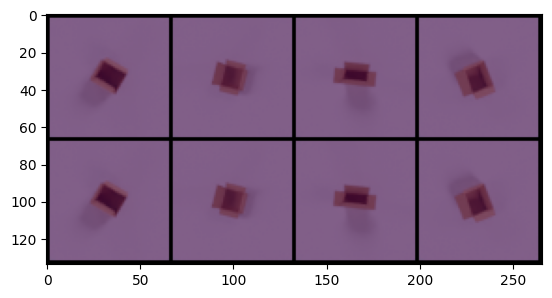

In [24]:
from argparse import ArgumentParser
from typing import List, Tuple

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

from keypoint_detection.utils.heatmap import generate_channel_heatmap

# Kelly's 22 colors for max contrast
DISTINCT_COLORS = [
    "#F2F3F4", "#222222", "#F3C300", "#875692", "#F38400", "#A1CAF1",
    "#BE0032", "#C2B280", "#848482", "#008856", "#E68FAC", "#0067A5",
    "#F99379", "#604E97", "#F6A600", "#B3446C", "#DCD300", "#882D17",
    "#8DB600", "#654522", "#E25822", "#2B3D26",
]

def get_logging_label_from_channel_configuration(channel_configuration: List[List[str]], mode: str) -> str:
    channel_name = channel_configuration
    if isinstance(channel_configuration, list):
        if len(channel_configuration) == 1:
            channel_name = channel_configuration[0]
        else:
            channel_name = f"{channel_configuration[0]}+{channel_configuration[1]}+..."
    channel_name_short = (channel_name[:40] + "...") if len(channel_name) > 40 else channel_name
    if mode != "":
        label = f"{channel_name_short}_{mode}"
    else:
        label = channel_name_short
    return label

def overlay_image_with_heatmap(images: torch.Tensor, heatmaps: torch.Tensor, alpha=0.5) -> torch.Tensor:
    """Overlay the images with heatmap."""
    viridis = plt.colormaps["viridis"]  # Corrected colormap access
    heatmaps = viridis(heatmaps.numpy())[..., :3]  # viridis: grayscale -> RGBa
    heatmaps = torch.tensor(heatmaps, dtype=torch.float32)
    heatmaps = heatmaps.permute((0, 3, 1, 2))  # HxWxC -> CxHxW for pytorch

    overlayed_images = alpha * images + (1 - alpha) * heatmaps
    return overlayed_images

def visualize_predicted_heatmaps(
    imgs: torch.Tensor,
    predicted_heatmaps: torch.Tensor,
    gt_heatmaps: torch.Tensor,
):
    num_images = min(predicted_heatmaps.shape[0], 6)

    predicted_heatmap_overlays = overlay_image_with_heatmap(imgs[:num_images], predicted_heatmaps[:num_images])
    gt_heatmap_overlays = overlay_image_with_heatmap(imgs[:num_images], gt_heatmaps[:num_images])

    images = torch.cat([predicted_heatmap_overlays, gt_heatmap_overlays])
    grid = torchvision.utils.make_grid(images, nrow=num_images)
    return grid

def overlay_images_with_keypoints(images: torch.Tensor, keypoints: List[torch.Tensor], sigma: float) -> torch.Tensor:
    image_size = images.shape[2:]
    alpha = 0.7
    keypoint_color = torch.Tensor([240.0, 240.0, 10.0]) / 255.0
    keypoint_color = keypoint_color.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
    overlayed_images = []
    for i in range(images.shape[0]):

        heatmaps = generate_channel_heatmap(image_size, keypoints[i], sigma=sigma, device="cpu")
        heatmaps = heatmaps.unsqueeze(0)  # 1 xC x H x W
        colorized_heatmaps = keypoint_color * heatmaps
        combined_heatmap = torch.max(colorized_heatmaps, dim=1)[0]  # 3 x H x W
        combined_heatmap[combined_heatmap < 0.1] = 0.0  # avoid glare

        overlayed_image = images[i] * alpha + combined_heatmap
        overlayed_image = torch.clip(overlayed_image, 0.0, 1.0)
        overlayed_images.append(overlayed_image)
    overlayed_images = torch.stack(overlayed_images)
    return overlayed_images

def draw_keypoints_on_image(
    image: Image, image_keypoints: List[List[Tuple[int, int]]], channel_configuration: List[List[str]]
) -> Image:
    color_pool = DISTINCT_COLORS
    image_size = image.size
    min_size = min(image_size)
    scale = 1 + (min_size // 256)

    draw = ImageDraw.Draw(image)
    for channel_idx, channel_keypoints in enumerate(image_keypoints):
        for keypoint_idx, keypoint in enumerate(channel_keypoints):
            u, v = keypoint
            draw.ellipse((u - scale, v - scale, u + scale, v + scale), fill=color_pool[channel_idx])

        draw.text(
            (10, channel_idx * 10 * scale),
            get_logging_label_from_channel_configuration(channel_configuration[channel_idx], ""),
            fill=color_pool[channel_idx],
            font=ImageFont.truetype("FreeMono.ttf", size=10 * scale),
        )

    return image

def visualize_predicted_keypoints(
    images: torch.Tensor, keypoints: List[List[List[List[int]]]], channel_configuration: List[List[str]]
):
    drawn_images = []
    num_images = min(images.shape[0], 6)
    for i in range(num_images):
        image = images[i].permute(1, 2, 0).numpy() * 255
        image = image.astype(np.uint8)
        image = Image.fromarray(image)
        image = draw_keypoints_on_image(image, keypoints[i], channel_configuration)
        drawn_images.append(image)

    drawn_images = torch.stack([torch.from_numpy(np.array(image)).permute(2, 0, 1) / 255 for image in drawn_images])

    grid = torchvision.utils.make_grid(drawn_images, nrow=num_images)
    return grid

if __name__ == "__main__":
    import matplotlib.pyplot as plt
    from torch.utils.data import DataLoader

    from keypoint_detection.data.coco_dataset import COCOKeypointsDataset
    from keypoint_detection.tasks.train import parse_channel_configuration
    from keypoint_detection.utils.heatmap import create_heatmap_batch

    # Set the paths here directly
    json_dataset_path = "/kaggle/working/keypoint-detection/test/test_dataset/coco_dataset.json"
    keypoint_channel_configuration = "/path/to/your/keypoint/channel/config"  # Replace with your actual path

    # Parse the channel configuration
    hparams = {
        "json_dataset_path": json_dataset_path,
        "keypoint_channel_configuration": parse_channel_configuration(keypoint_channel_configuration),
    }

    dataset = COCOKeypointsDataset(**hparams)
    batch_size = 6
    dataloader = DataLoader(dataset, batch_size, shuffle=False, num_workers=0, collate_fn=dataset.collate_fn)
    images, keypoint_channels = next(iter(dataloader))

    shape = images.shape[2:]

    heatmaps = create_heatmap_batch(shape, keypoint_channels[0], sigma=6.0, device="cpu")
    grid = visualize_predicted_heatmaps(images, heatmaps, heatmaps)

    image_numpy = grid.permute(1, 2, 0).numpy()
    plt.imshow(image_numpy)
    plt.show()


***MEtrics***

In [25]:
"""
Implementation of (mean) Average Precision metric for 2D keypoint detection.
"""

from __future__ import annotations  # allow typing of own class objects

import copy
import math
from dataclasses import dataclass
from typing import Callable, Dict, List, Tuple

import torch
from torchmetrics import Metric
from torchmetrics.utilities import check_forward_full_state_property


@dataclass
class Keypoint:
    """A simple class datastructure for Keypoints,
    dataclass is chosen over named tuple because this class is inherited by other classes
    """

    u: int
    v: int

    def l2_distance(self, keypoint: Keypoint):
        return math.sqrt((self.u - keypoint.u) ** 2 + (self.v - keypoint.v) ** 2)


@dataclass
class DetectedKeypoint(Keypoint):
    probability: float


@dataclass(unsafe_hash=True)
class ClassifiedKeypoint(DetectedKeypoint):
    """
    DataClass for a classified keypoint, where classified means determining if the detection is a True Positive of False positive,
     with the given treshold distance and the gt keypoints from the frame

    a hash is required for torch metric
    cf https://github.com/PyTorchLightning/metrics/blob/2c8e46f87cb67186bff2c7b94bf1ec37486873d4/torchmetrics/metric.py#L570
    unsafe_hash -> dirty fix to allow for hash w/o explictly telling python the object is immutable.
    """

    threshold_distance: int
    true_positive: bool


def keypoint_classification(
    detected_keypoints: List[DetectedKeypoint],
    ground_truth_keypoints: List[Keypoint],
    threshold_distance: int,
) -> List[ClassifiedKeypoint]:
    """Classifies keypoints of a **single** frame in True Positives or False Positives by searching for unused gt keypoints in prediction probability order
    that are within distance d of the detected keypoint (greedy matching).

    Args:
        detected_keypoints (List[DetectedKeypoint]): The detected keypoints in the frame
        ground_truth_keypoints (List[Keypoint]): The ground truth keypoints of a frame
        threshold_distance: maximal distance in pixel coordinate space between detected keypoint and ground truth keypoint to be considered a TP

    Returns:
        List[ClassifiedKeypoint]: Keypoints with TP label.
    """
    classified_keypoints: List[ClassifiedKeypoint] = []

    ground_truth_keypoints = copy.deepcopy(
        ground_truth_keypoints
    )  # make deep copy to do local removals (pass-by-reference..)

    for detected_keypoint in sorted(detected_keypoints, key=lambda x: x.probability, reverse=True):
        matched = False
        for gt_keypoint in ground_truth_keypoints:
            distance = detected_keypoint.l2_distance(gt_keypoint)
            # add small epsilon to avoid numerical errors
            if distance <= threshold_distance + 1e-5:
                classified_keypoint = ClassifiedKeypoint(
                    detected_keypoint.u,
                    detected_keypoint.v,
                    detected_keypoint.probability,
                    threshold_distance,
                    True,
                )
                matched = True
                # remove keypoint from gt to avoid muliple matching
                ground_truth_keypoints.remove(gt_keypoint)
                break
        if not matched:
            classified_keypoint = ClassifiedKeypoint(
                detected_keypoint.u,
                detected_keypoint.v,
                detected_keypoint.probability,
                threshold_distance,
                False,
            )
        classified_keypoints.append(classified_keypoint)

    return classified_keypoints


def calculate_precision_recall(
    classified_keypoints: List[ClassifiedKeypoint], total_ground_truth_keypoints: int
) -> Tuple[List[float], List[float]]:
    """Calculates precision recall points on the curve for the given keypoints by varying the treshold probability to all detected keypoints
     (i.e. by always taking one additional keypoint als a predicted event)

    Note that this function is tailored towards a Detector, not a Classifier. For classifiers, the outputs contain both TP, FP and FN. Whereas for a Detector the
    outputs only define the TP and the FP; the FN are not contained in the output as the point is exactly that the detector did not detect this event.

    A detector is a ROI finder + classifier and the ROI finder could miss certain regions, which results in FNs that are hence never passed to the classifier.

    This also explains why the scikit average_precision function states it is for Classification tasks only. Since it takes "total_gt_events" to be the # of positive_class labels.
    The function can however be used by using as label (TP = 1, FP = 0) and by then multiplying the result with TP/(TP + FN) since the recall values are then corrected
    to take the unseen events (FN's) into account as well. They do not matter for precision calcultations.
    Args:
        classified_keypoints (List[ClassifiedKeypoint]):
        total_ground_truth_keypoints (int):

    Returns:
        Tuple[List[float], List[float]]: precision, recall entries. First entry is (1,0); last entry is (0,1).
    """
    precision = [1.0]
    recall = [0.0]

    true_positives = 0
    false_positives = 0

    for keypoint in sorted(classified_keypoints, key=lambda x: x.probability, reverse=True):
        if keypoint.true_positive:
            true_positives += 1
        else:
            false_positives += 1

        precision.append(_zero_aware_division(true_positives, (true_positives + false_positives)))
        recall.append(_zero_aware_division(true_positives, total_ground_truth_keypoints))

    precision.append(0.0)
    recall.append(1.0)
    return precision, recall


def calculate_ap_from_pr(precision: List[float], recall: List[float]) -> float:
    """Calculates the Average Precision using the AUC definition (COCO-style)

    # https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173
    # AUC AP.

    Args:
        precision (List[float]):
        recall (List[float]):

    Returns:
        (float): average precision (between 0 and 1)
    """

    smoothened_precision = copy.deepcopy(precision)

    for i in range(len(smoothened_precision) - 2, 0, -1):
        smoothened_precision[i] = max(smoothened_precision[i], smoothened_precision[i + 1])

    ap = 0
    for i in range(len(recall) - 1):
        ap += (recall[i + 1] - recall[i]) * smoothened_precision[i + 1]

    return ap


class KeypointAPMetric(Metric):
    """torchmetrics-like interface for the Average Precision implementation"""

    full_state_update = False

    def __init__(self, keypoint_threshold_distance: float, dist_sync_on_step=False):
        """

        Args:
            keypoint_threshold_distance (float): distance from ground_truth keypoint that is used to classify keypoint as TP or FP.
        """

        super().__init__(dist_sync_on_step=dist_sync_on_step)

        self.keypoint_threshold_distance = keypoint_threshold_distance

        default: Callable = lambda: []
        self.add_state("classified_keypoints", default=default(), dist_reduce_fx="cat")  # list of ClassifiedKeypoints
        self.add_state("total_ground_truth_keypoints", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, detected_keypoints: List[DetectedKeypoint], gt_keypoints: List[Keypoint]):

        classified_img_keypoints = keypoint_classification(
            detected_keypoints, gt_keypoints, self.keypoint_threshold_distance
        )

        self.classified_keypoints += classified_img_keypoints

        self.total_ground_truth_keypoints += len(gt_keypoints)

    def compute(self):
        p, r = calculate_precision_recall(self.classified_keypoints, int(self.total_ground_truth_keypoints.cpu()))
        m_ap = calculate_ap_from_pr(p, r)
        return m_ap


class KeypointAPMetrics(Metric):
    """
    Torchmetrics-like interface for calculating average precisions over different keypoint_threshold_distances.
    Uses KeypointAPMetric class.
    """

    full_state_update = False

    def __init__(self, keypoint_threshold_distances: List[int], dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)

        self.ap_metrics = [KeypointAPMetric(dst, dist_sync_on_step) for dst in keypoint_threshold_distances]

    def update(self, detected_keypoints: List[DetectedKeypoint], gt_keypoints: List[Keypoint]):
        for metric in self.ap_metrics:
            metric.update(detected_keypoints, gt_keypoints)

    def compute(self) -> Dict[float, float]:
        result_dict = {}
        for metric in self.ap_metrics:
            result_dict.update({metric.keypoint_threshold_distance: metric.compute()})
        return result_dict

    def reset(self) -> None:
        for metric in self.ap_metrics:
            metric.reset()


def _zero_aware_division(num: float, denom: float) -> float:
    if num == 0:
        return 0
    if denom == 0 and num != 0:
        return float("inf")
    else:
        return num / denom


if __name__ == "__main__":
    print(
        check_forward_full_state_property(
            KeypointAPMetric,
            init_args={"keypoint_threshold_distance": 2.0},
            input_args={"detected_keypoints": [DetectedKeypoint(10, 20, 0.02)], "gt_keypoints": [Keypoint(10, 23)]},
        )
    )


Full state for 10 steps took: 0.004137965384870768+-0.001
Partial state for 10 steps took: 0.003+-0.001
Full state for 100 steps took: 0.12354826927185059+-0.000
Partial state for 100 steps took: 0.119+-0.001
Full state for 1000 steps took: 10.206430435180664+-0.141
Partial state for 1000 steps took: 10.140+-0.140
Recommended setting `full_state_update=False`
None


***load detectors***

In [26]:
print('helooo')

helooo


In [27]:
import wandb
from pathlib import Path
import torch
from keypoint_detection.models.backbones.backbone_factory import BackboneFactory
from keypoint_detection.models.detector import KeypointDetector

# Login to W&B manually if not already done
wandb.login()

def get_model_from_wandb_checkpoint(checkpoint_reference: str):
    """
    Get a model from a PyTorch Lightning checkpoint stored on W&B as an artifact.
    """
    # Start a W&B run
    with wandb.init(project="hardy-paper-6", entity="tinsaiebbs") as run:
        # Download checkpoint locally (if not already cached)
        artifact = run.use_artifact(checkpoint_reference, type="model")
        artifact_dir = artifact.download()
        checkpoint_path = Path(artifact_dir) / "model.ckpt"
        return load_from_checkpoint(checkpoint_path)

def load_from_checkpoint(checkpoint_path: str, hparams_to_override: dict = None):
    """
    Function to load a Keypoint Detector model from a local PyTorch Lightning checkpoint.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    checkpoint = torch.load(checkpoint_path, map_location=device)
    backbone = BackboneFactory.create_backbone(**checkpoint["hyper_parameters"])
    model = KeypointDetector.load_from_checkpoint(checkpoint_path, backbone=backbone, map_location=device)
    return model

if __name__ == "__main__":
    checkpoint_reference = "tinsaiebbs/hardy-paper-6/model-4um302zo:v0"
    model = get_model_from_wandb_checkpoint(checkpoint_reference)
    print(model.hparams)


wandb: Currently logged in as: tinsaiebbs (tinsaiebbss). Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: tinsaiebbs. Use `wandb login --relogin` to force relogin


CommError: failed to upsert bucket: returned error 403 Forbidden: {"errors":[{"message":"permission denied","path":["upsertBucket"],"extensions":{"code":"PERMISSION_ERROR"}}],"data":{"upsertBucket":null}}

In [ ]:
wandb.init(project="hardy-paper-6", entity="tinsaiebbs", mode="offline")


In [ ]:
wandb.init(project="hardy-paper-6", entity="tinsaiebbs", sync_tensorboard=False, settings=wandb.Settings(start_method="thread"))
